## Transfer Learning with Tensorflow, part 3 : Scaling Up

we have done  transfer learning feature extraction and fine tuning, now its time to scale up to all of the classes ( previously we done it with 10 classes )

Goal is to make a better model than the original ( https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf ) using only 10% data, the original manage to achieve 50% accuracy accross all classes using random forest algorithm.

In [3]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-05-24 09:20:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-05-24 09:20:27 (97.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [5]:
# Get Data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-05-24 09:20:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.199.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   211MB/s    in 7.7s    

2021-05-24 09:20:37 (202 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tiramisu'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bruschetta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/shrimp_and_grits'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/huevos_rancheros'.
There are 0 directories and 250 images in '1

In [7]:
# Setup inputs
import tensorflow as tf
imgsz = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=imgsz)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=imgsz,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Train a big model with transfer learning on 10% data

Steps :
- Create ModelCheckpoint
- Create Augmentation Layer
- Build headless functional backboned model, in this case, EfficientNetB0, we will create our own output layer
- Compile
- Feature extract for 5 full passes

In [8]:
#Create checkpoitn callbacks
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = 'val_accuracy',
                                                         save_best_only = True)

In [9]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#setup augmentation layer
data_augmentation = Sequential([
                                preprocessing.RandomFlip('horizontal'),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2)
],name = 'data_augmentation')

In [10]:
# setup base model
basemodel = tf.keras.applications.EfficientNetB0(include_top=False)
basemodel.trainable = False

# model architecture
input = layers.Input(shape=(224,224,3), name='input')
x = data_augmentation(input)
x = basemodel(x, training=False)
x = layers.GlobalAveragePooling2D(name='globalavgpool')(x)
output = layers.Dense(101, activation = 'softmax', name='output')(x)
model = tf.keras.Model(input, output)

16711680/16705208 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
globalavgpool (GlobalAverage (None, 1280)              0         
_________________________________________________________________
output (Dense)               (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [13]:
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
          epochs = 5,
          validation_data = test_data,
          validation_steps=int(0.15 * len(test_data)),
          callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 131s 395ms/step - loss: 4.0079 - accuracy: 0.1493 - val_loss: 2.6733 - val_accuracy: 0.4060
Epoch 2/5
237/237 [==============================] - 79s 331ms/step - loss: 2.4223 - accuracy: 0.4530 - val_loss: 2.2067 - val_accuracy: 0.4717
Epoch 3/5
237/237 [==============================] - 71s 297ms/step - loss: 1.9795 - accuracy: 0.5292 - val_loss: 2.0480 - val_accuracy: 0.4899
Epoch 4/5
237/237 [==============================] - 66s 278ms/step - loss: 1.7563 - accuracy: 0.5802 - val_loss: 2.0025 - val_accuracy: 0.4891
Epoch 5/5
237/237 [==============================] - 62s 261ms/step - loss: 1.5863 - accuracy: 0.6139 - val_loss: 1.9405 - val_accuracy: 0.4984


In [14]:
results = model.evaluate(test_data)
results

790/790 [==============================] - 101s 128ms/step - loss: 1.7279 - accuracy: 0.5486


[1.7279397249221802, 0.5485544800758362]

Our own baseline model already performed 10% better than the original. pog

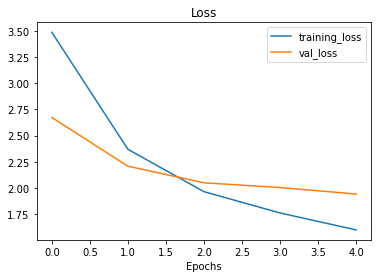

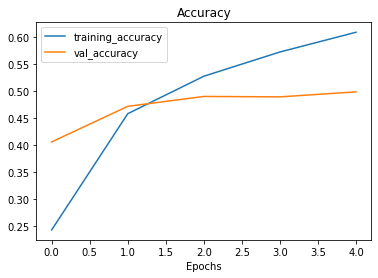

In [15]:
plot_loss_curves(history_all_classes_10_percent)

however the curves does not look good, the model overfitted.

# Fine TUning

to avoid the model overfittinng, we can fine tune the model by unfreezing the last x amouint of layers so i can adapt to our problem.

In [16]:
basemodel.trainable = True

# Refreeze every layer except for the last 5
for layer in basemodel.layers[:-5]:
  layer.trainable = False

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than default to avoid overfiutting
              metrics=['accuracy'])

In [18]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input True
data_augmentation True
efficientnetb0 True
globalavgpool True
output True


In [19]:
for layer_number, layer in enumerate(basemodel.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [20]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=0.15*(len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])


Epoch 5/10
237/237 [==============================] - 69s 266ms/step - loss: 1.3840 - accuracy: 0.6443 - val_loss: 1.9748 - val_accuracy: 0.4861
Epoch 6/10
237/237 [==============================] - 60s 253ms/step - loss: 1.2379 - accuracy: 0.6730 - val_loss: 1.9535 - val_accuracy: 0.4940
Epoch 7/10
237/237 [==============================] - 59s 247ms/step - loss: 1.1545 - accuracy: 0.6962 - val_loss: 1.9149 - val_accuracy: 0.5105
Epoch 8/10
237/237 [==============================] - 58s 241ms/step - loss: 1.0693 - accuracy: 0.7128 - val_loss: 1.9479 - val_accuracy: 0.5011
Epoch 9/10
237/237 [==============================] - 58s 244ms/step - loss: 1.0149 - accuracy: 0.7321 - val_loss: 1.9447 - val_accuracy: 0.5034
Epoch 10/10
237/237 [==============================] - 56s 236ms/step - loss: 0.9483 - accuracy: 0.7465 - val_loss: 1.9290 - val_accuracy: 0.5137


In [21]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 100s 127ms/step - loss: 1.6209 - accuracy: 0.5763


[1.620938777923584, 0.5762772560119629]

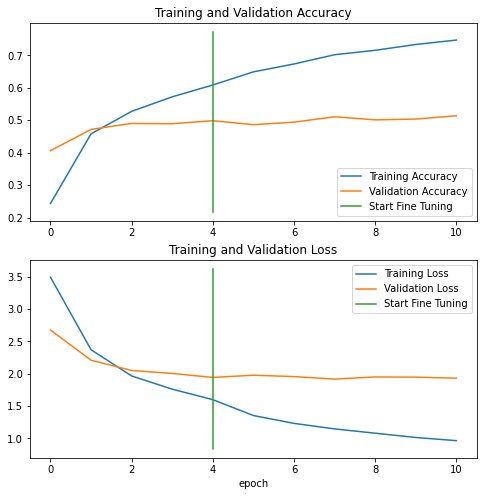

In [22]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

while the model show improvement, the model still overfitted.

# Saving model

In [23]:
 # Save model to drive so it can be used later 
model.save("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_model")

INFO:tensorflow:Assets written to: drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_model/assets


In [24]:
loadedmodel = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_model")

In [25]:
loadedmodelresults = loadedmodel.evaluate(test_data)
loadedmodelresults

790/790 [==============================] - 101s 126ms/step - loss: 1.6209 - accuracy: 0.5763


[1.620938777923584, 0.5762772560119629]

In [26]:
results_all_classes_10_percent_fine_tune

[1.620938777923584, 0.5762772560119629]

#evaluating performance of the model across all different classes

we have a trained and saved model. which perform better than the original.


In [27]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

--2021-05-24 09:40:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.199.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   134MB/s    in 0.3s    

2021-05-24 09:40:14 (134 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [28]:
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 103s 128ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

the downloaded model is the same with the model we manually created but has been re-trained resulting better result, slightly.

# Make predictions

In [94]:
pred_prob = model.predict(test_data, verbose=1)

790/790 [==============================] - 102s 129ms/step


In [95]:
pred_prob

array([[5.95420077e-02, 3.57419503e-06, 4.13768589e-02, ...,
        1.41386813e-09, 8.35307583e-05, 3.08974274e-03],
       [9.64016676e-01, 1.37532707e-09, 8.47805641e-04, ...,
        5.42872003e-05, 7.83623513e-12, 9.84663906e-10],
       [9.59258676e-01, 3.25335823e-05, 1.48669467e-03, ...,
        7.18913384e-07, 5.43973158e-07, 4.02759651e-05],
       ...,
       [1.51386812e-05, 4.09729080e-04, 8.02504729e-10, ...,
        2.17428951e-05, 1.07972137e-05, 5.37899673e-01],
       [5.93180070e-03, 4.92367009e-03, 9.98233911e-03, ...,
        1.19895376e-04, 1.68903516e-05, 4.52178493e-02],
       [3.13634276e-02, 7.50525435e-03, 4.29749110e-04, ...,
        5.03465650e-04, 5.20560570e-06, 6.90628946e-01]], dtype=float32)

the prediction result are probability of each class, so unlike binary classification where it only have 2 classes where we can round up the probability of both class and get the prediction, we are dealing with 101 classes with their own probability.

In [96]:
pred_class = pred_prob.argmax(axis=1) #return the position with most value

In [97]:
pred_class

array([ 52,   0,   0, ..., 100,  94, 100])

Item #1 is class 52, #2 is class 0, etc etc

In [33]:
test_data.class_names[0]

'apple_pie'

In [34]:
min(pred_class), max(pred_class)

(0, 100)

now we have value between 0 to 100, each number representing certain class

# EValuation

In [35]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

we need to unravel our test data BatchDataset so it comparable with pred_class

In [36]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [37]:
import numpy as np
np.array(y_labels)

array([  0,   0,   0, ..., 100, 100, 100])

In [91]:
pred_class

array([11])

now we have both labels in same shape, we can evaluate them using confusion matrix

In [39]:
from sklearn.metrics import accuracy_score

In [40]:
accuracy = accuracy_score(y_true=y_labels, y_pred=pred_class)

In [41]:
accuracy

0.6077623762376237

In [42]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

# Confusion Matrix

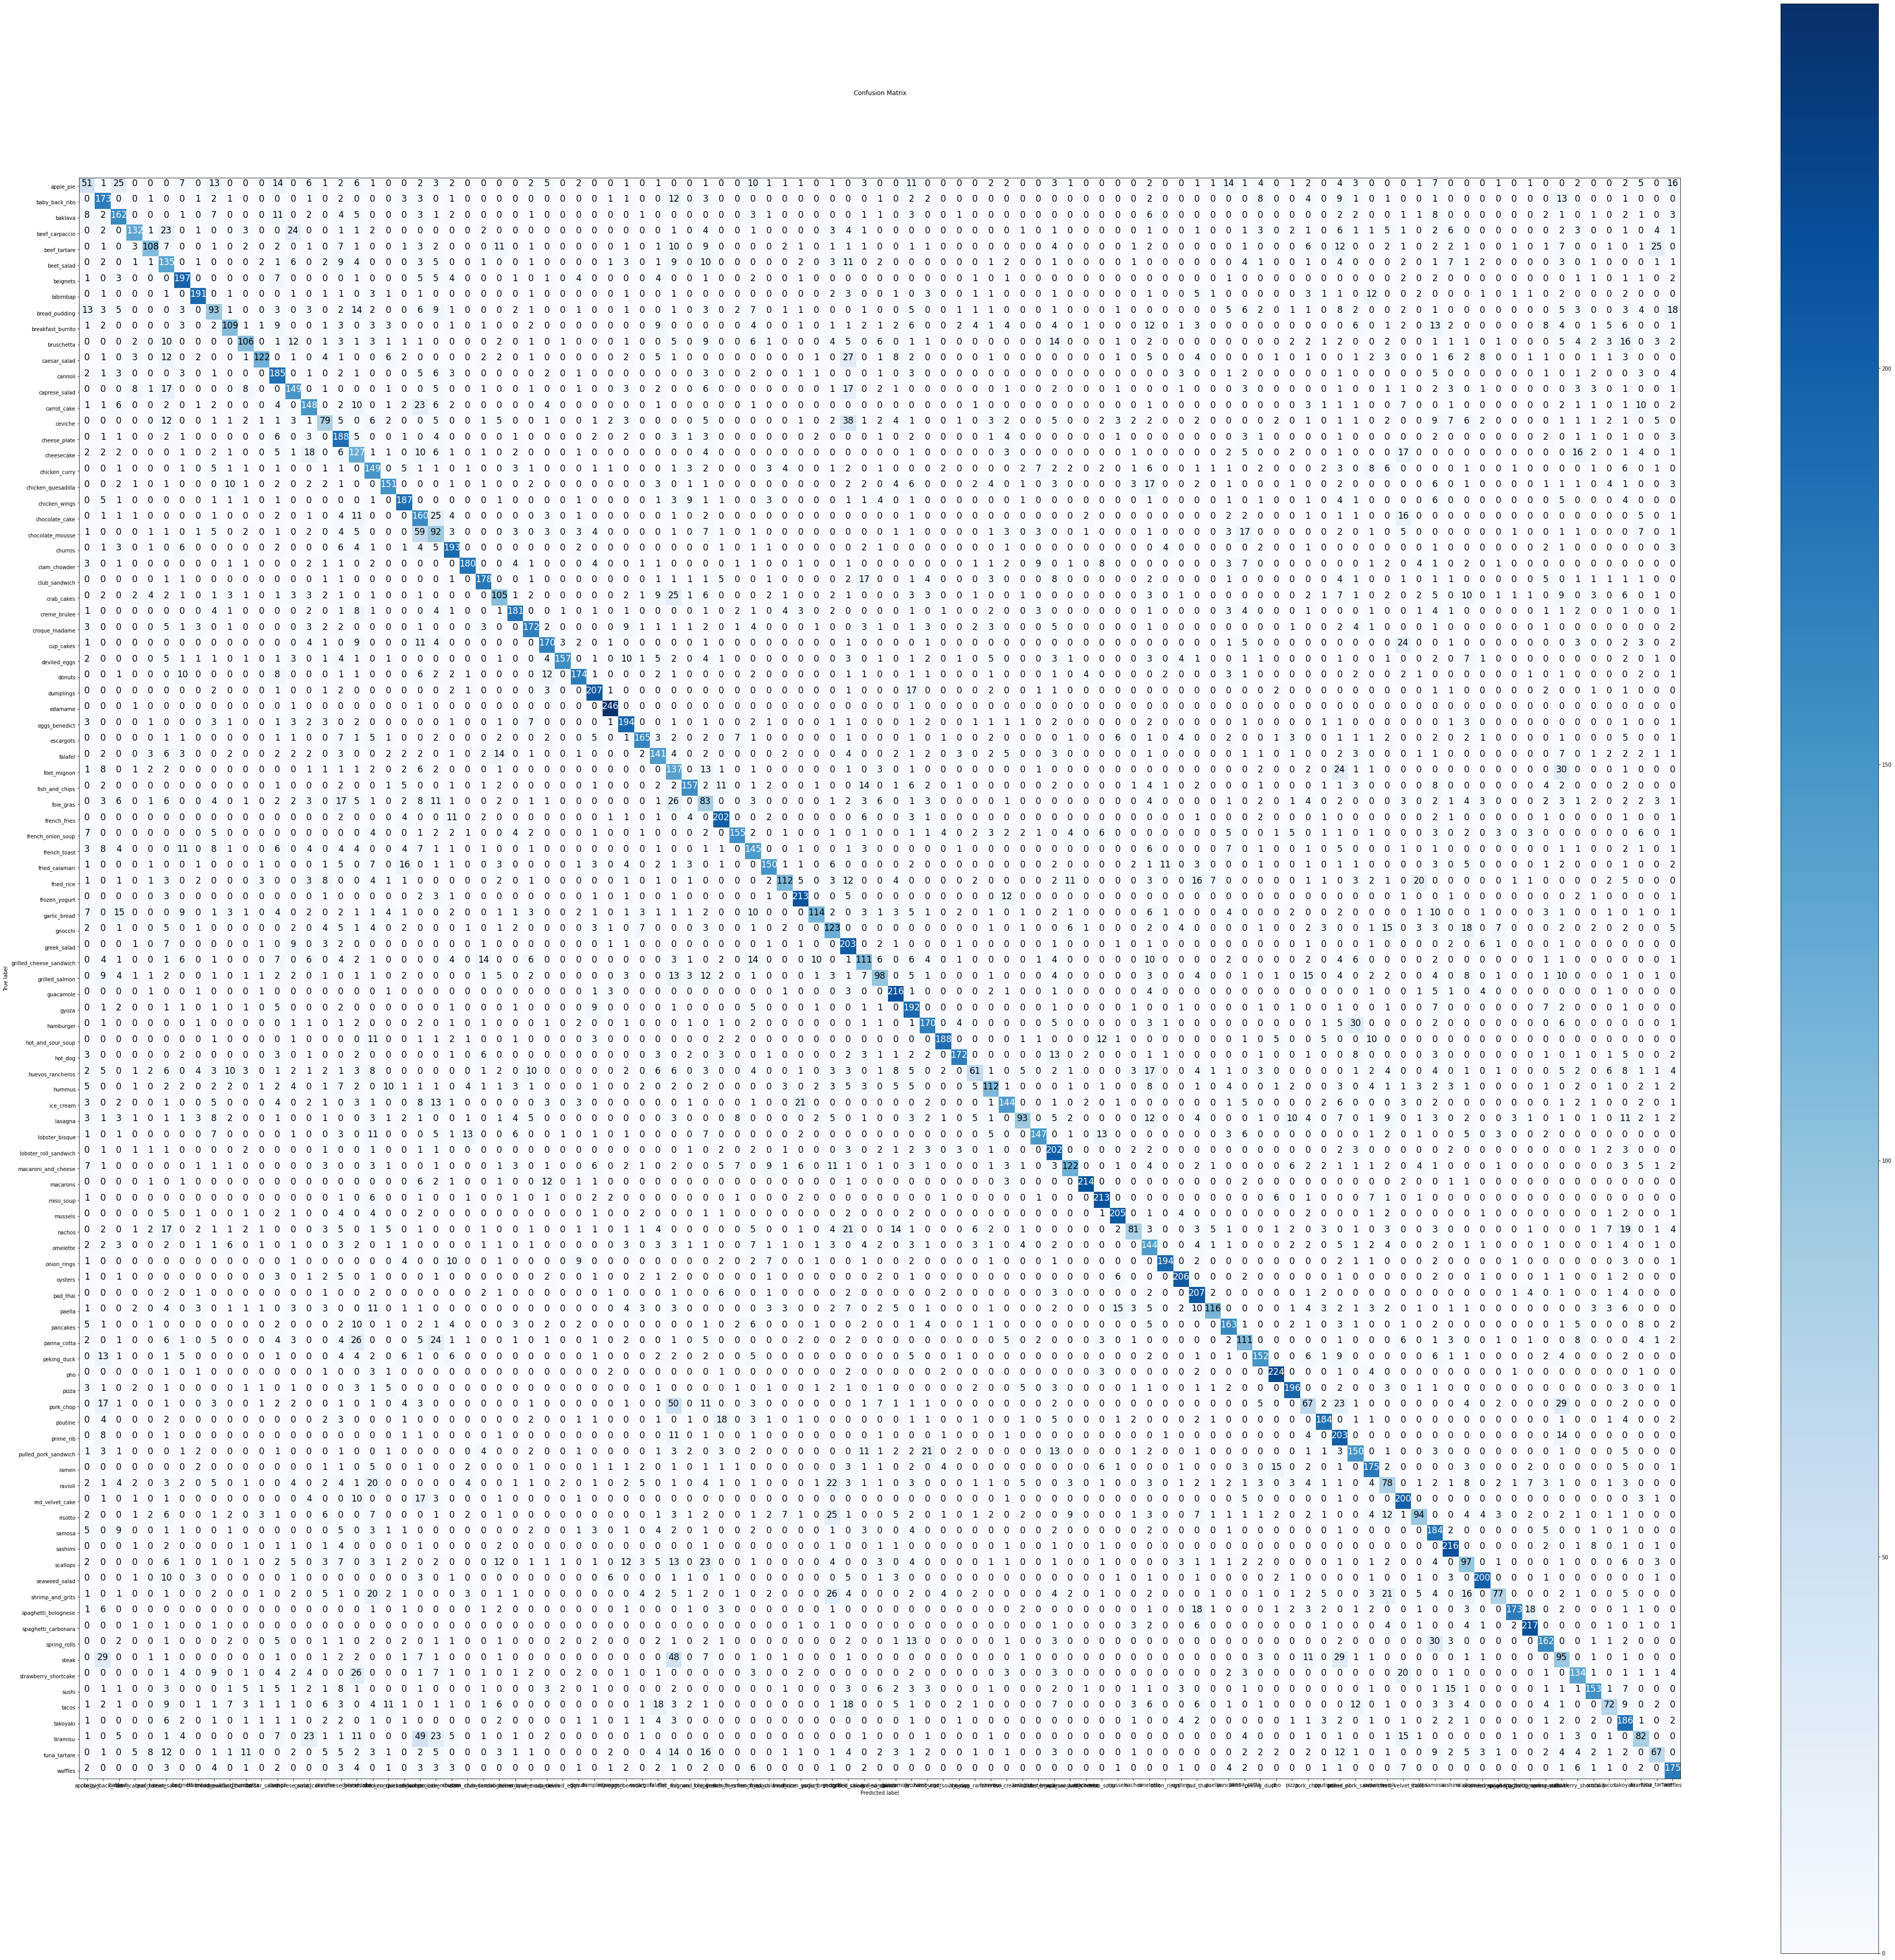

In [43]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_labels, pred_class, classes=test_data.class_names, figsize=(69, 69), text_size=17)

# Classification Report

using scikit.learn function to to acquire metrics report on every class


In [44]:
from sklearn.metrics import classification_report

In [45]:
print(classification_report(y_true=y_labels,
                      y_pred = pred_class))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [53]:
classification_report_dict = classification_report(y_true=y_labels,
                      y_pred = pred_class, output_dict = True) #returned key value dict so we can visualize the resutl

In [55]:
class_names = test_data.class_names

lets just plot the F1 score so the plot wont be cluttered

F1 score are combination of recall and precision

In [56]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [57]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


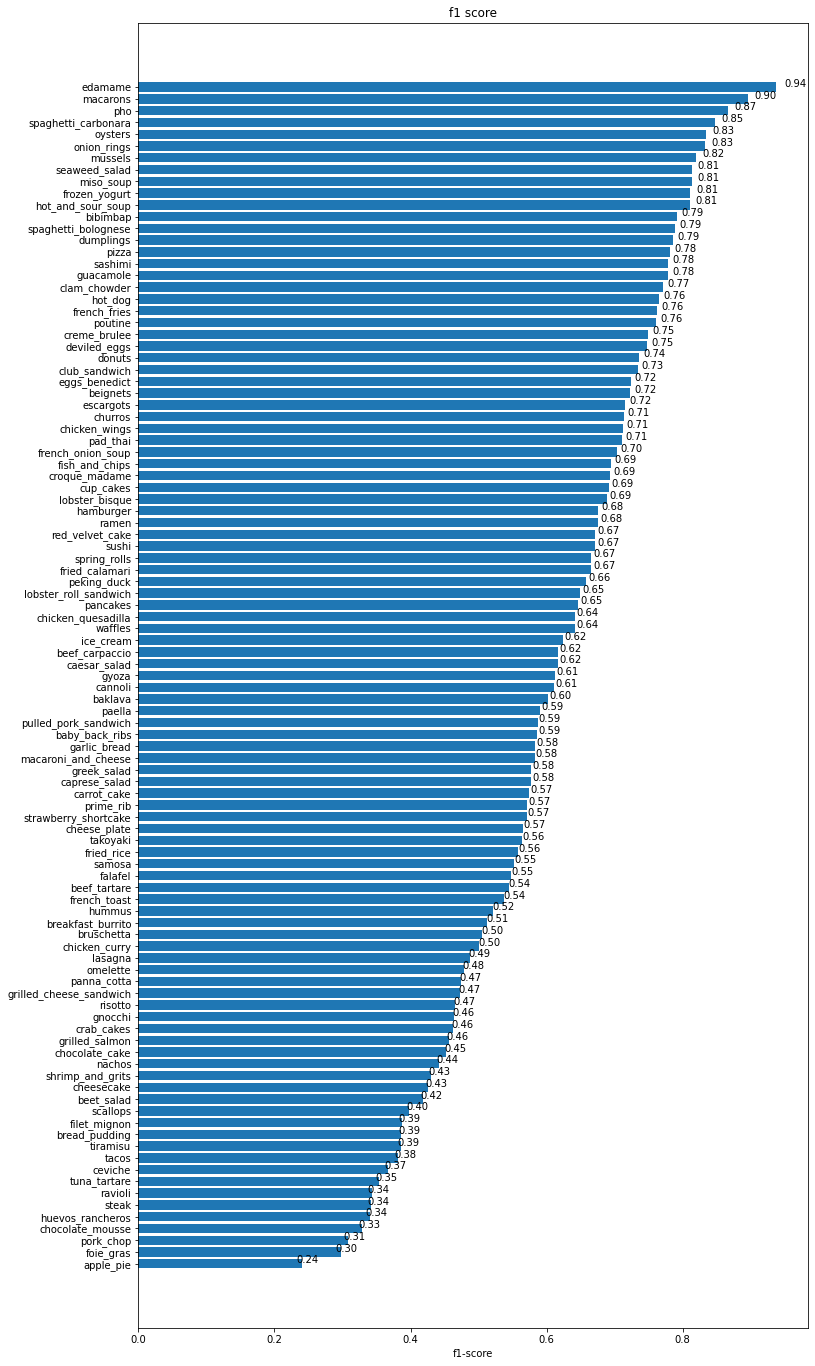

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 24))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores['class_name']))
ax.set_xlabel('f1-score')
ax.set_title('f1 score')
ax.invert_yaxis()

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

# Visualizing predicition

Make function to load and preprocess image so we can feed it to the model then get the result.

- read target image filepath using tf.io.read_file()
- turn the image into tensor using tf.io.decode_image()
- resize to the same size we train our model on using tf.image.resize()
- scale the image to value between 0 and 1

In [66]:
def loadandprep(filename, imgshape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [imgshape, imgshape])
  if scale:
    return img/225.
  else:
    return img

now write code to:
1. load random test data
2. make prediction
3. plot the image along with the prediction and its confidence/probaility

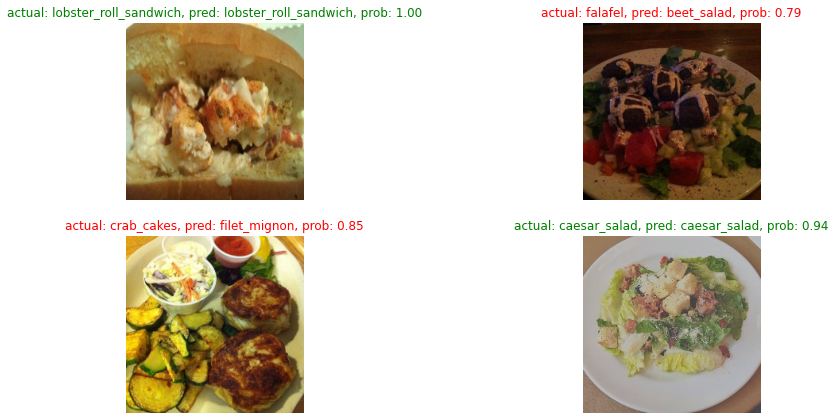

In [76]:
import os
import random

plt.figure(figsize=(15, 15))
for i in range(4):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = loadandprep(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(4, 2, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

# Finding the most wrong predictions

It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These most wrong predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:

- Get all of the image file paths in the test dataset using the list_files() method.
- Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
Note: We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
- Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
- Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
- Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [77]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

Now we've got all of the test image filepaths, let's combine them into a DataFrame along with:

- Their ground truth labels (y_labels).
- The class the model predicted (pred_classes).
- The maximum prediction probabilitity value (pred_probs.max(axis=1)).
- The ground truth class names.
- The predicted class names.

In [98]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_class,
                        "pred_conf": pred_prob.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_class]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.847419,apple_pie,gyoza
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.964017,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.959259,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,80,0.658606,apple_pie,pulled_pork_sandwich
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,79,0.367900,apple_pie,prime_rib


In [99]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.847419,apple_pie,gyoza,False
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.964017,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.959259,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,80,0.658606,apple_pie,pulled_pork_sandwich,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,79,0.367900,apple_pie,prime_rib,False


In [100]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
21810,b'101_food_classes_10_percent/test/scallops/17...,87,29,0.999997,scallops,cup_cakes,False
231,b'101_food_classes_10_percent/test/apple_pie/8...,0,100,0.999995,apple_pie,waffles,False
15359,b'101_food_classes_10_percent/test/lobster_rol...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'101_food_classes_10_percent/test/strawberry_...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'101_food_classes_10_percent/test/samosa/3140...,85,92,0.999981,samosa,spring_rolls,False
24540,b'101_food_classes_10_percent/test/tiramisu/16...,98,83,0.999947,tiramisu,red_velvet_cake,False
2511,b'101_food_classes_10_percent/test/bruschetta/...,10,61,0.999945,bruschetta,lobster_roll_sandwich,False
5574,b'101_food_classes_10_percent/test/chocolate_m...,22,21,0.999939,chocolate_mousse,chocolate_cake,False
17855,b'101_food_classes_10_percent/test/paella/2314...,71,65,0.999931,paella,mussels,False
23797,b'101_food_classes_10_percent/test/sushi/16593...,95,86,0.999904,sushi,sashimi,False


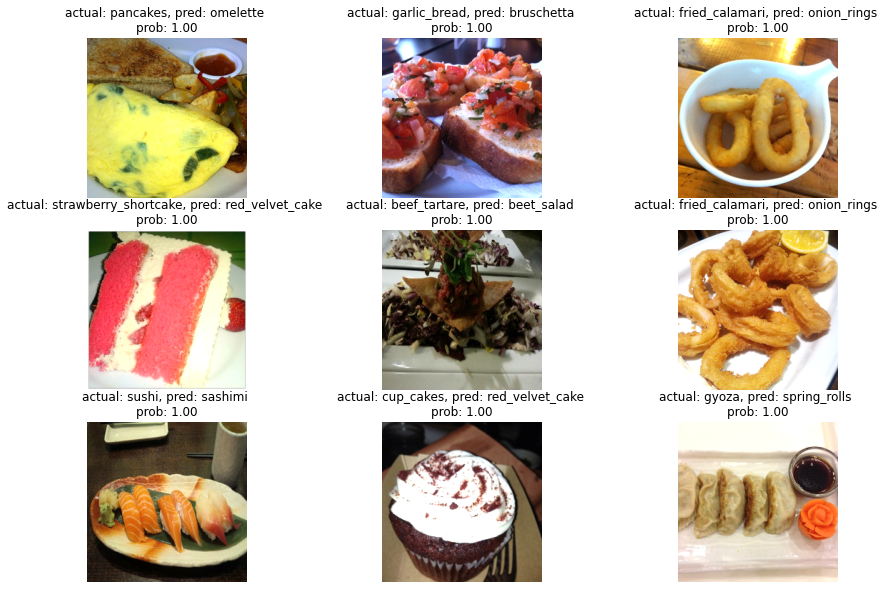

In [102]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = loadandprep(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

Go to "Saving Model" Section to load the model so you dont have to run the training again to play with this notebook.